In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [47]:
format_plots()
#format_pizza_plots()

In [48]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [49]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
#path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet')
df = pd.read_parquet(path)

In [50]:
## update data
def filter_df(df):
    max=100
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [51]:
# arrange data
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
ages = data.index.get_level_values('age')
mice = data.index.get_level_values('uuid')
#data = data.to_numpy()

In [52]:
#pcs = PCA(n_components=2).fit_transform(np.log(data + 1e-6))
pcs = PCA(n_components=2).fit_transform(data)

pc_df = pd.DataFrame(pcs)
pc_df['age'] = ages

In [53]:
pca = PCA(n_components=2)
#pca.fit_transform(np.log(data + 1e-6))
pca.fit_transform(data)


# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)

In [54]:
cumulative_variance_explained

array([0.36468631, 0.56664271])

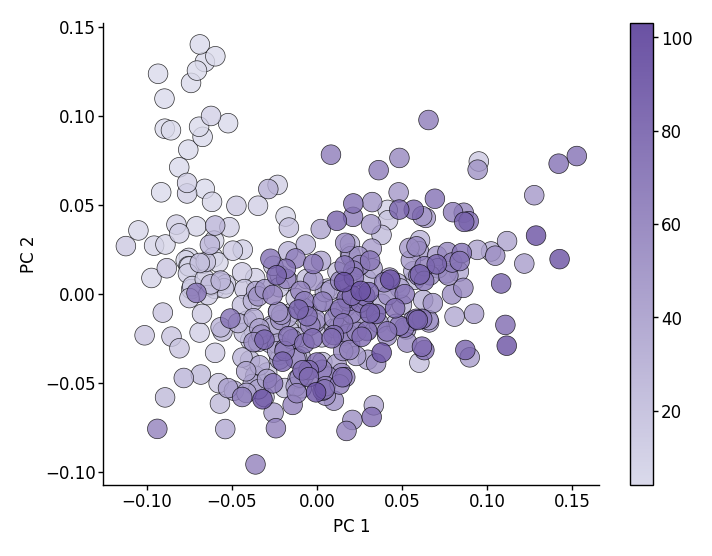

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
sns.scatterplot(data=pc_df, x=pc_df[0], y=pc_df[1], 
                hue="age",
                palette=cmm,
                legend="full",
                s=50,
                alpha=0.8,
                edgecolor='black',
                linewidth=0.25,
                ax=ax
               )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
#plt.title("pca males")
sns.despine()

norm = plt.Normalize(pc_df['age'].min(), pc_df['age'].max())
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.show()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'D_PCA_pre.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


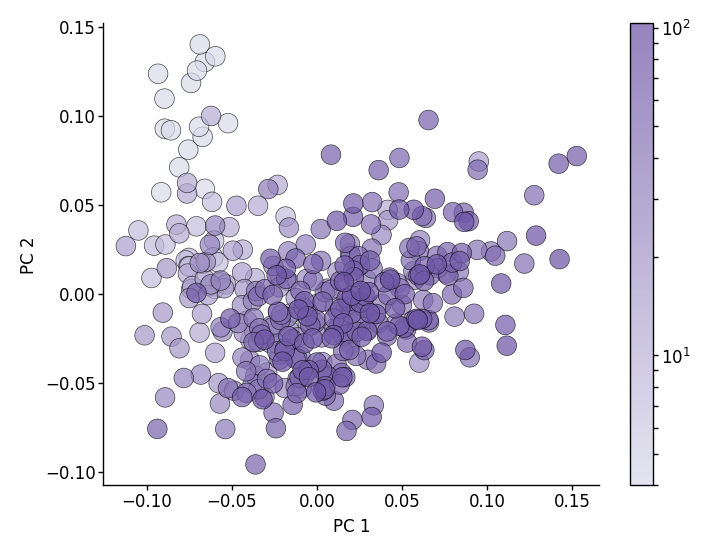

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
im=plt.scatter(x=pc_df[0], y=pc_df[1], 
                cmap=cmm,
                s=50,
                alpha=0.7,
                edgecolor='black',
                c=pc_df['age'], 
                linewidth=0.25,
                norm='log'
               )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
sns.despine()
ax.get_legend().remove()
cb=fig.colorbar(im,ax=ax)

#plt.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'pca_ontogeny_pre.pdf', bbox_inches='tight')

Text(0.5, 0, 'PC3')

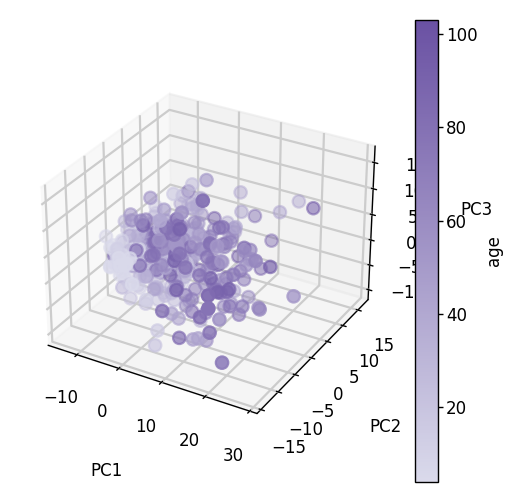

In [12]:
## 3D scatter
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module

pcs3 = PCA(n_components=3).fit_transform(np.log(data + 1e-6))
ages = data.index.get_level_values('age')
pc3_df = pd.DataFrame(pcs3)
pc3_df['age'] = ages

# Create a 3D figure
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pc3_df[0], pc3_df[1], pc3_df[2], c=ages, cmap=cmm)

cbar = plt.colorbar(scatter)
cbar.set_label('age')

# Set custom viewing angles (elevation, azimuthal)
#ax.view_init(elev=50, azim=150)

# Set labels for each axis
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [57]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'pca_ontogeny_pre.pdf', bbox_inches='tight')
#saver(fig,'pca_ontogeny_pre.pdf', tight_layout=True);

In [58]:
#PC1 correlation
from scipy import stats
[c,p] = stats.spearmanr(pc_df[0], ages)

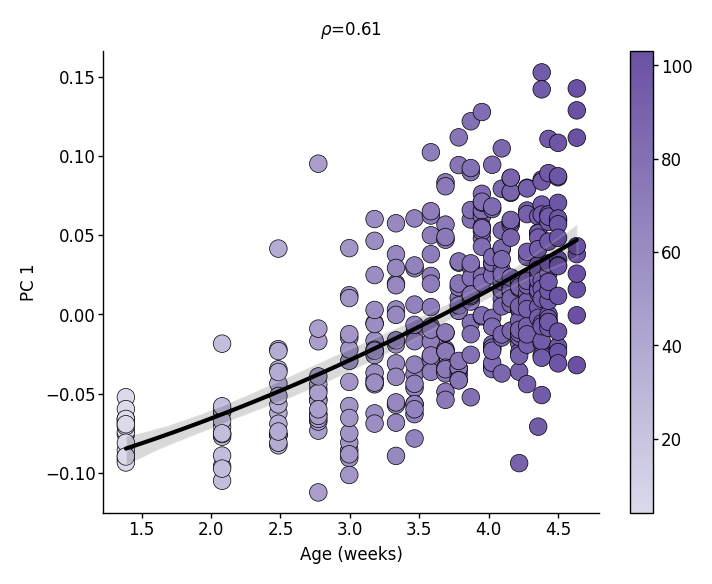

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=np.log(pc_df['age']), y=pc_df[0], 
            s=40, 
            c=pc_df['age'], 
            edgecolor='black',
            linewidth=0.25,
            norm='log',
            cmap=cmm)
#ax = sns.regplot(data=pc_df, x='age', y=pc_df[0], scatter=False, color='black', logx=True)
ax = sns.regplot(x=np.log(pc_df['age']), y=pc_df[0], scatter=False, color='black', 
                 #logx=True, 
                 order=2)
ax.set(xlabel='Age (weeks)', ylabel='PC 1')
plt.title(f'$\\rho$={c:0.2f}')
norm = plt.Normalize(pc_df['age'].min(), pc_df['age'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig2"/ 'D_PCA_pre_correaltion.pdf', bbox_inches='tight')

In [60]:
#PC1 correlation
from scipy import stats
[c,p] = stats.spearmanr(pc_df[0], ages)
#[c,p] = stats.pearsonr(pc_df[0], ages)

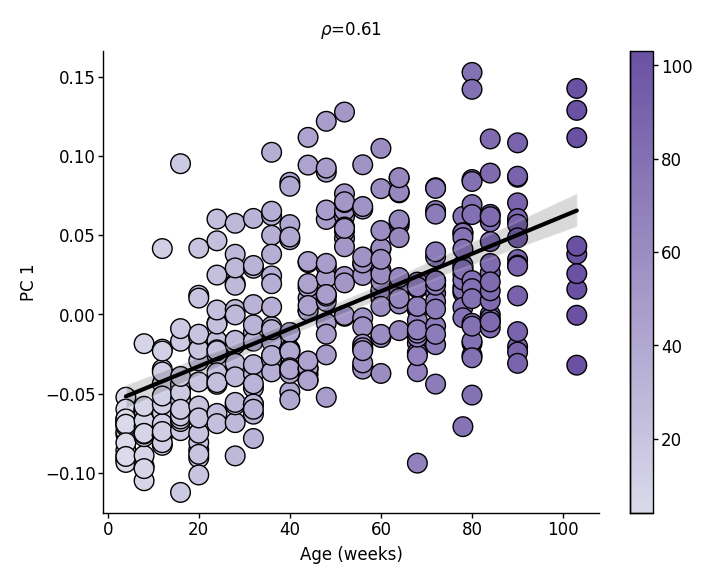

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
im = plt.scatter(x=pc_df['age'], y=pc_df[0], 
            s=50, 
            c=pc_df['age'], 
            edgecolor='black',
            linewidth=0.5,
            #norm='log',
            cmap=cmm)
cb=fig.colorbar(im,ax=ax)
plt.title(f'$\\rho$={c:0.2f}')
ax = sns.regplot(data=pc_df, x='age', y=pc_df[0], scatter=False, color='black', logx=False)
ax.set(xlabel='Age (weeks)', ylabel='PC 1')
sns.despine()

In [62]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'D_PCA_pre_correlation.pdf', bbox_inches='tight')

In [63]:
## explore pc space

In [68]:
npc = 15

pca = PCA(n_components=npc)
#pcsn = pca.fit_transform(np.log(data + 1e-6))
pcsn = pca.fit_transform(data)
ages = data.index.get_level_values('age')
pcn_df = pd.DataFrame(pcsn)
pcn_df['age'] = ages

In [69]:
# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print(cumulative_variance_explained)

[0.36468631 0.56664271 0.65236031 0.70263615 0.74095667 0.77086709
 0.79844646 0.82217465 0.84200822 0.85874735 0.8709412  0.8828062
 0.89270634 0.90104374 0.908922  ]


In [70]:
pcn_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,age
0,-0.091528,0.056991,0.000519,-0.014678,0.002478,0.000873,0.019933,-0.005164,-0.017143,0.011893,0.003206,0.011397,-0.017133,0.006501,0.013992,4
1,-0.075628,0.080942,0.010808,-0.001943,0.013672,0.020283,0.012847,-0.020163,-0.004373,0.017010,-0.002603,0.002219,0.003930,0.003920,0.002939,4
2,-0.067206,0.088143,0.014028,0.006721,-0.000683,0.023268,0.005659,-0.010351,0.008702,0.018124,-0.003283,0.004490,0.003632,-0.000015,0.005147,4
3,-0.065865,0.130219,0.004384,0.012225,0.004228,0.012793,-0.001857,-0.005535,0.018193,0.010360,-0.001483,0.000051,0.004128,-0.000885,0.004561,4
4,-0.089444,0.092721,0.007417,-0.009891,0.004917,0.012996,0.012096,-0.007529,0.018319,0.006513,-0.002790,0.005796,0.003632,0.005900,-0.000526,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.025721,0.001595,-0.047191,0.035974,0.015350,0.010790,-0.001265,-0.005085,0.014214,-0.026767,-0.007437,0.011717,0.017251,0.001470,-0.001630,103
356,0.043111,0.007924,-0.048840,0.029229,0.031380,0.009726,0.010822,0.011842,0.006713,-0.009703,-0.005918,-0.013325,0.012571,-0.019921,0.002018,103
357,-0.000521,-0.055367,-0.011524,0.008490,-0.007077,0.014040,-0.005168,-0.030326,0.011749,-0.003157,0.011348,0.021110,0.029035,-0.001464,0.003342,103
358,0.142598,0.019449,-0.052053,0.031208,0.021413,-0.001436,-0.017234,0.017726,0.008464,0.019431,-0.010144,0.027517,-0.008503,-0.008767,-0.004719,103


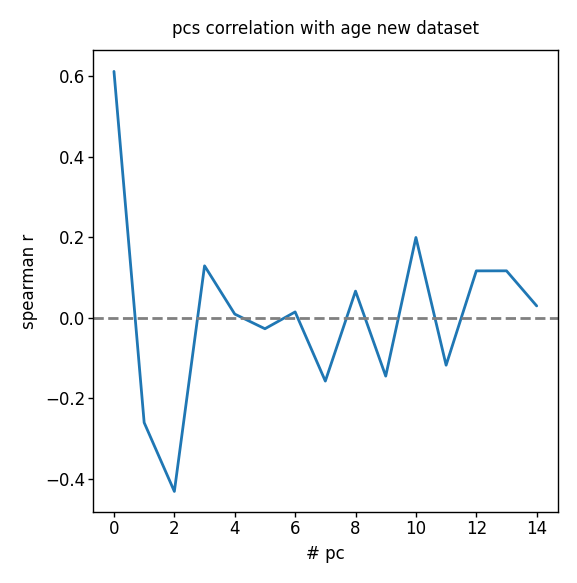

In [71]:
correlations = pcn_df.loc[:,0:14].apply(lambda col: col.corr(pcn_df['age'], method='spearman'))
fig, ax = plt.subplots()
sns.lineplot(correlations)
plt.title('pcs correlation with age new dataset')
plt.xlabel('# pc')
plt.ylabel('spearman r')
ax.axhline(y=0, color='gray', linestyle='--')

In [72]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'D_all_pcs_pre_correlation.pdf', bbox_inches='tight')